<a href="https://colab.research.google.com/github/sidrusiya/AILA_KFolds/blob/main/AILA_Task2_XL_Lemmatized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import nltk
import re
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import seaborn as sns
import gensim
nltk.download('all')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
!pip3 install tensorflow_text
import tensorflow_text
!pip install -q tf-models-official
!pip install -q -U tensorflow-text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_hub as hub
import tensorflow_text as tf_text

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [4]:
dataset = open('/content/drive/MyDrive/nit_agartala_nlp_team_3.tsv', 'r')
df = pd.read_csv(dataset, sep='\t')

In [5]:
df.head()

,judge_id,id,sentence,relevance,lem_text,stem_text
0,1,1,Appeal by special leave from the order dated ...,0,appeal special leave order dated government pu...,appeal special leav order date govern punjab (...
1,2,1,From the Judgment and Order dated . . of the ...,0,judgment order dated . . bombay high court app...,judgment order date . . bombay high court appe...
2,3,1,Appeal from the judgment and decree dated rd/t...,0,appeal judgment decree dated rd/th calcutta hi...,appeal judgment decre date rd/th calcutta high...
3,4,1,of .,0,.,.
4,5,1,From the Judgment and order dated . . of the ...,0,judgment order dated . . allahabad high court ...,judgment order date . . allahabad high court c...


In [6]:
df1 = df[df['judge_id'] <= 400]
df2 = df[df['judge_id'] > 400]

df1

,judge_id,id,sentence,relevance,lem_text,stem_text
0,1,1,Appeal by special leave from the order dated ...,0,appeal special leave order dated government pu...,appeal special leav order date govern punjab (...
1,2,1,From the Judgment and Order dated . . of the ...,0,judgment order dated . . bombay high court app...,judgment order date . . bombay high court appe...
2,3,1,Appeal from the judgment and decree dated rd/t...,0,appeal judgment decree dated rd/th calcutta hi...,appeal judgment decre date rd/th calcutta high...
3,4,1,of .,0,.,.
4,5,1,From the Judgment and order dated . . of the ...,0,judgment order dated . . allahabad high court ...,judgment order date . . allahabad high court c...
...,...,...,...,...,...,...
72187,27,2541,The petitioner before us does not complain tha...,0,petitioner u complain got proper grounds.,petition us complain got proper grounds.
72188,27,2542,Further the period of his detention under the ...,0,period detention impugned act gone beyond thre...,period detent impugn act gone beyond three mon...
72189,27,2543,Petition dismissed.,0,petition dismissed.,petit dismissed.
72190,27,2544,Agent for the petitioner: S. Subrahmanyam.,0,agent petitioner: s. subrahmanyam.,agent petitioner: s. subrahmanyam.


In [7]:
df2

,judge_id,id,sentence,relevance,lem_text,stem_text
400,401,1,Appeal by special leave from the judgment and ...,0,appeal special leave judgment order dated _the...,appeal special leav judgment order date _the m...
401,402,1,Appeal from Judgment and Order dated the th da...,0,appeal judgment order dated th day june high c...,appeal judgment order date th day june high co...
402,403,1,Appeal by Special leave from the Judgment and ...,0,appeal special leave judgment order dated rd j...,appeal special leav judgment order date rd jan...
403,404,1,From the Judgment and Order dated . . of the ...,0,judgment order dated . . andhra pradesh admini...,judgment order date . . andhra pradesh adminis...
404,405,1,Appeal by Special Leave from the Award of the ...,0,appeal special leave award industrial tribunal...,appeal special leav award industri tribun guja...
...,...,...,...,...,...,...
69217,409,1201,The interim orders passed by this Court are va...,0,interim order passed court vacated.,interim order pass court vacated.
69223,409,1202,The amount of rupees which the Indian shareho...,0,amount rupee indian shareholder directed pay h...,amount rupe indian sharehold direct pay hold c...
69229,409,1203,The interim Board of Directors shall forthwith...,1,interim board director shall forthwith hand ch...,interim board director shall forthwith hand ch...
69235,409,1204,After taking the charge from the interim Board...,0,taking charge interim board board director tak...,take charg interim board board director take e...


In [8]:
max_classes = len(df.relevance.unique())
max_length=128

In [9]:
!pip3 install transformers
!pip install sentencepiece
from transformers import AutoTokenizer, TFXLNetModel

# Same as before

checkpoint = "xlnet-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, max_length=max_length)

     |████████████████████████████████| 3.3 MB 10.9 MB/s 
     |████████████████████████████████| 3.3 MB 38.6 MB/s 
     |████████████████████████████████| 61 kB 458 kB/s 
     |████████████████████████████████| 895 kB 35.4 MB/s 


Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [10]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 3
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
batch_size = 32

# num_train_steps =  len((balanced_df.NumLabel) // batch_size) * EPOCHS
# lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
#                                end_learning_rate=0.,
#                                decay_steps=num_train_steps
#                                )

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=5e-5)

In [11]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result = shuffle(df1)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(result.lem_text, result.relevance, 
                                                    test_size = 0.1, random_state = 42, stratify =result.relevance)

In [13]:
max_classes = len(df.relevance.unique())
print(max_classes)

2


In [14]:
%%time
encoded_labels_train = to_categorical(Y_train, num_classes=max_classes)
encoded_labels_test = to_categorical(Y_test, num_classes=max_classes)

CPU times: user 1.96 ms, sys: 645 µs, total: 2.6 ms
Wall time: 2.99 ms


In [15]:
def XLNet_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in tqdm(range(len(data))):
      encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [16]:
def get_inputs(tweets, tokenizer, max_len=120):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in tweets]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

In [17]:
%%time
train_inp_tok, train_attention_masks, segments = get_inputs(X_train, tokenizer)
test_inp_tok, test_attention_masks, segments = get_inputs(X_test, tokenizer)

print(train_inp_tok.shape, test_inp_tok.shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(53892, 120) (5988, 120)
CPU times: user 16.7 s, sys: 941 ms, total: 17.7 s
Wall time: 17.7 s


In [18]:
print(f'Number of Samples in Training Set : {len(X_train)} Number of Samples in Validation Set: {len(X_test)} ')

Number of Samples in Training Set : 53892 Number of Samples in Validation Set: 5988 


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!mkdir checkpoints

MyCheckpoint = ModelCheckpoint('XLNet-base.h5',
                               monitor = 'val_categorical_accuracy',
                               verbose = 1,
                               save_best_only = True,
                               mode='auto',
                               save_weights_only = True)

MyEarlyStopping = EarlyStopping(patience =1,
                                monitor='val_categorical_accuracy',
                                restore_best_weights = True,
                                verbose = 1)

import os
os.path.exists('/content/checkpoints')

True

In [20]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight(class_weight='balanced'
                                               ,classes=np.unique(df1.relevance)
                                               ,y=df1.relevance)

class_weights_array

array([0.6463312, 2.2084532])

In [21]:
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
class_weights

{0: 0.6463311961660514, 1: 2.2084531976100905}

In [22]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa

# macro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='macro')
# micro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='micro')
# weighted_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='weighted')
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()
categorical_accuracry = tf.metrics.CategoricalAccuracy()

class F1_metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        # Initialize our metric by initializing the two metrics it's based on:
        # Precision and Recall
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update our metric by updating the two metrics it's based on
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        # To get the F1 result, we compute the harmonic mean of the current
        # precision and recall
        return 2 / ((1 / self.precision.result()) + (1 / self.recall.result())) 

F1Score = F1_metric()
metrics = [categorical_accuracry, F1Score]

In [23]:
def create_model(xlnet_model):
  input_ids = tf.keras.Input(shape=(max_length,),dtype='int32')

  attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')
  
#   output = xlnet_model([input_ids,attention_masks])
  output = xlnet_model(input_ids)
  output = output[0]
  output = tf.squeeze(output[:, -1:, :], axis=1)
  
#   output = tf.keras.layers.Dense(128,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

#   output = tf.keras.layers.Dense(64,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)
  
  output = tf.keras.layers.Dense(units=max_classes,activation='softmax')(output)
  model = tf.keras.models.Model(inputs = input_ids,outputs = output)
  model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)
  return model

In [24]:
def create_xlnet(mname):
    """ Creates the model. It is composed of the XLNet main block and then
    a classification head its added
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')
    attention_masks = tf.keras.Input(shape=(120,),dtype='int32')
    # Call XLNet model
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs, attention_masks)[0]

    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output 
    outputs = tf.keras.layers.Dense(units=max_classes,activation='softmax')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs, attention_masks], outputs=[outputs])
    model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)

    return model

In [25]:
from transformers import TFXLNetModel
xlnet_model = TFXLNetModel.from_pretrained(checkpoint)
# from transformers import TFAutoModelForSequenceClassification
# model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=max_classes)

model = create_xlnet(checkpoint)
# model.layers[2].trainable = False
model.summary()

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel fro

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 word_inputs (InputLayer)       [(None, 120)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 120)]        0           []                               
                                                                                                  
 tfxl_net_model_1 (TFXLNetModel  TFXLNetModelOutput(  116718336  ['word_inputs[0][0]',            
 )                              last_hidden_state=(               'input_1[0][0]']                
                                None, 120, 768),                                                  
                                 mems=((120, None,                                            

In [26]:
%%time
history = model.fit([train_inp_tok, train_attention_masks], encoded_labels_train, 
                    validation_data=([test_inp_tok, test_attention_masks], encoded_labels_test),
                    epochs = 3,
                    batch_size = 32,    
                    verbose = 1,
                    class_weight=class_weights,
                    callbacks = [MyCheckpoint, MyEarlyStopping]
                    )

Epoch 1/3
1685/1685 [==============================] - ETA: 0s - loss: 0.7152 - categorical_accuracy: 0.5783 - f1_score: 0.5783
Epoch 00001: val_categorical_accuracy improved from -inf to 0.44105, saving model to XLNet-base.h5
1685/1685 [==============================] - 3277s 2s/step - loss: 0.7152 - categorical_accuracy: 0.5783 - f1_score: 0.5783 - val_loss: 0.7632 - val_categorical_accuracy: 0.4410 - val_f1_score: 0.4410
Epoch 2/3
1685/1685 [==============================] - ETA: 0s - loss: 0.6193 - categorical_accuracy: 0.6532 - f1_score: 0.6532
Epoch 00002: val_categorical_accuracy improved from 0.44105 to 0.64395, saving model to XLNet-base.h5
1685/1685 [==============================] - 3255s 2s/step - loss: 0.6193 - categorical_accuracy: 0.6532 - f1_score: 0.6532 - val_loss: 0.5849 - val_categorical_accuracy: 0.6440 - val_f1_score: 0.6440
Epoch 3/3
1685/1685 [==============================] - ETA: 0s - loss: 0.5424 - categorical_accuracy: 0.7143 - f1_score: 0.7143
Epoch 00003: 

In [27]:
final_test_inputs, final_test_attention_masks, segments = get_inputs(df2.lem_text, tokenizer)
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:
df2['pred_labels'] = y_preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


              precision    recall  f1-score   support

           0       0.80      0.74      0.77      9288
           1       0.35      0.43      0.38      3024

    accuracy                           0.66     12312
   macro avg       0.57      0.58      0.58     12312
weighted avg       0.69      0.66      0.67     12312



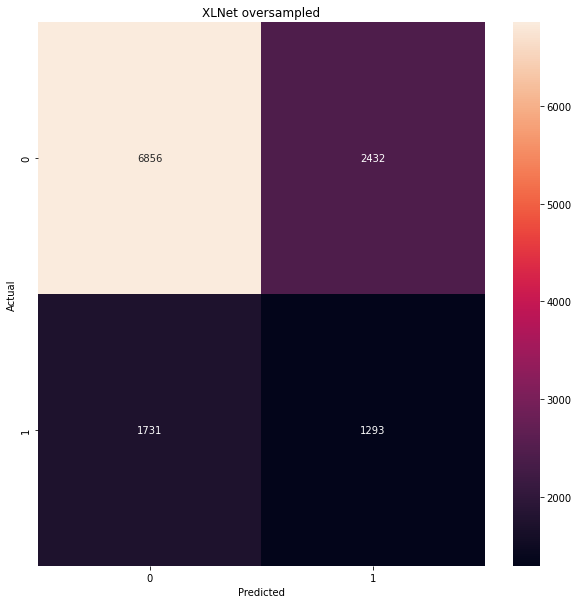

In [31]:
from sklearn.metrics import classification_report
print(classification_report(df2.relevance,df2.pred_labels))

import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(df2.relevance), list(df2['pred_labels']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(df2.relevance), yticklabels=set(df2.relevance))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('XLNet oversampled')
plt.show()

In [32]:
summary_file= pd.DataFrame(columns=['judge_id', 'summary', 'pred_summary'])
for i in range(100):
      summary_file= summary_file.append({'judge_id': i+401,  'summary': '', 'pred_summary': ''}, ignore_index=True)

In [33]:
for i in df2.index:
  if df2['relevance'][i]:
    summary_file['summary'][df2['judge_id'][i]-401]+=(df2['sentence'][i])
  if df2['pred_labels'][i]:
    summary_file['pred_summary'][df2['judge_id'][i]-401]+=(df2['sentence'][i])
  

summary_file

,judge_id,summary,pred_summary
0,401,The appellant is a firm consisting of six part...,This appeal by special leave raises the. quest...
1,402,Sannyasi charan Sadhukhan died in and his son...,The Judgment of the Court was delivered by DA...
2,403,The following question of law had been referre...,The following question of law had been referre...
3,404,Special leave granted.Pending prosecution with...,Special leave granted.For immediate reference ...
4,405,In the case of the Alembic Glass Industries li...,Speaking broadly the dispute in both cases rel...
...,...,...,...
95,496,Punjab Excise Act has been extended to Delhi....,To illumine the contours of controversy events...
96,497,In support of his first contention reliance wa...,- was passed the th April and a decree absolu...
97,498,These appointments seem to have been made vari...,The Government of Madhya Pradesh reorganised B...
98,499,The revenue authorities sanctioned mutation of...,Kala Singh has died leaving his sons Dewan Sin...


In [34]:
!pip install rouge

from rouge import Rouge

rouge = Rouge()

In [35]:
rouge_scores= pd.DataFrame(columns=['r1_f', 'r1_p', 'r1_r', 'r2_f', 'r2_p', 'r2_r', 'rl_f', 'rl_p', 'rl_r'])

#for i in range(100):
  #rouge_scores= rouge_scores.append({'r1_f': 0.0 , 'r1_p': 0.0 , 'r1_r': 0.0 , 'r2_f': 0.0 , 'r2_p': 0.0 , 'r2_r': 0.0 , 'rl_f': 0.0 , 'rl_p': 0.0 , 'rl_r': 0.0 }, ignore_index=True)


for i in summary_file.index:
    if(summary_file['summary'][i]==''):
      summary_file['summary'][i]+="Empty"
    if(summary_file['pred_summary'][i]==''):
      summary_file['pred_summary'][i]+="Empty"
    scores = rouge.get_scores(summary_file['pred_summary'][i], summary_file['summary'][i])
    rouge_scores= rouge_scores.append({'r1_f': scores[0]['rouge-1']['f'] , 'r1_p': scores[0]['rouge-1']['p'] , 'r1_r': scores[0]['rouge-1']['r'] , 'r2_f': scores[0]['rouge-2']['f'] , 'r2_p': scores[0]['rouge-2']['p'] , 'r2_r': scores[0]['rouge-2']['r'] , 'rl_f': scores[0]['rouge-l']['f'] , 'rl_p': scores[0]['rouge-l']['p'] , 'rl_r': scores[0]['rouge-l']['r'] }, ignore_index=True)


rouge_scores

,r1_f,r1_p,r1_r,r2_f,r2_p,r2_r,rl_f,rl_p,rl_r
0,0.730512,0.615770,0.897810,0.602296,0.491273,0.778152,0.718634,0.605757,0.883212
1,0.515464,0.349162,0.984252,0.419238,0.269860,0.939024,0.511340,0.346369,0.976378
2,0.710502,0.575444,0.928401,0.612678,0.476865,0.856658,0.706849,0.572485,0.923628
3,0.584475,0.659794,0.524590,0.456010,0.527221,0.401747,0.566210,0.639175,0.508197
4,0.680992,0.564384,0.858333,0.583919,0.478261,0.749499,0.671074,0.556164,0.845833
...,...,...,...,...,...,...,...,...,...
95,0.740923,0.771795,0.712426,0.666359,0.687143,0.646795,0.729846,0.760256,0.701775
96,0.625000,0.560976,0.705521,0.507812,0.454545,0.575221,0.597826,0.536585,0.674847
97,0.628688,0.579737,0.686667,0.430427,0.387960,0.483333,0.594100,0.547842,0.648889
98,0.633147,0.507463,0.841584,0.533679,0.416442,0.742788,0.614525,0.492537,0.816832


In [36]:
r1mean_f = rouge_scores['r1_f'].mean()
print('rouge-1 AVERAGE_F is',r1mean_f)
r1mean_p = rouge_scores['r1_p'].mean()
print('rouge-1 AVERAGE_P is',r1mean_p)
r1mean_r = rouge_scores['r1_r'].mean()
print('rouge-1 AVERAGE_R is',r1mean_r)
r2mean_f = rouge_scores['r2_f'].mean()
print('rouge-2 AVERAGE_F is',r2mean_f)
r2mean_p = rouge_scores['r2_p'].mean()
print('rouge-2 AVERAGE_P is',r2mean_p)
r2mean_r = rouge_scores['r2_r'].mean()
print('rouge-2 AVERAGE_R is',r2mean_r)
rlmean_f = rouge_scores['rl_f'].mean()
print('rouge-l AVERAGE_F is',rlmean_f)
rlmean_p = rouge_scores['rl_p'].mean()
print('rouge-l AVERAGE_P is',rlmean_p)
rlmean_r = rouge_scores['rl_r'].mean()
print('rouge-l AVERAGE_R is',rlmean_r)

rouge-1 AVERAGE_F is 0.5989459930314943
rouge-1 AVERAGE_P is 0.5480773131967389
rouge-1 AVERAGE_R is 0.7150262664520335
rouge-2 AVERAGE_F is 0.4630875314843146
rouge-2 AVERAGE_P is 0.4255569522258095
rouge-2 AVERAGE_R is 0.5732756316862582
rouge-l AVERAGE_F is 0.5794796093896005
rouge-l AVERAGE_P is 0.5304211452601083
rouge-l AVERAGE_R is 0.6914128379944381
